#VAEGAN with LSTM

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix,roc_auc_score,average_precision_score
from lightgbm import LGBMClassifier

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

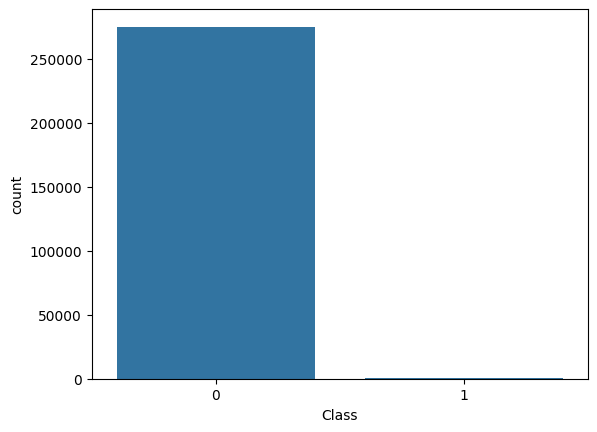

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

#Training GAN

#Generating new samples

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import numpy as np

# ------------------------------------------------------------
# Custom VAE Model
# ------------------------------------------------------------
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, input_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                losses.mse(x, reconstruction) * self.input_dim
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_vae_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_vae_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total_vae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# ------------------------------------------------------------
# VAE implementation:
# ------------------------------------------------------------
latent_dim = 16
input_dim = X_train.shape[1]

# Encoder: maps input to mean and log-variance of latent code
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_inputs)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder: reconstructs input from latent code
decoder_inputs = layers.Input(shape=(latent_dim,))
d = layers.Dense(32, activation='relu')(decoder_inputs)
d = layers.Dense(64, activation='relu')(d)
decoder_outputs = layers.Dense(input_dim, activation='linear')(d)
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

# VAE model
vae = VAE(encoder, decoder, input_dim)

# Compile with a dummy loss and explicitly list metrics
vae.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=[
    vae.total_loss_tracker,
    vae.reconstruction_loss_tracker,
    vae.kl_loss_tracker,
])

# Get only fraud samples for training VAE and VAE-GAN
fraud_samples = X_train[y_train == 1]

print("Training VAE...")
# Removed validation_split
vae.fit(fraud_samples, epochs=50, batch_size=256, verbose=0)
print("VAE Training complete.")

# Generate synthetic fraud samples by sampling latent space and decoding
def vae_generate(n_samples):
    z_rand = np.random.normal(size=(n_samples, latent_dim))
    return decoder.predict(z_rand)

# ------------------------------------------------------------
# 2. VAE‑GAN implementation (simplified):
# ------------------------------------------------------------
# Encoder and decoder as above
# Discriminator for VAE‑GAN
def build_vae_gan_discriminator(input_dim):
    d_in = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(d_in)
    x = layers.Dense(64, activation='relu')(x)
    d_out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(d_in, d_out, name='vae_gan_discriminator')

discriminator = build_vae_gan_discriminator(input_dim)
discriminator.compile(optimizer=optimizers.Adam(1e-4),
                      loss='binary_crossentropy')

# Combined VAE‑GAN model
# 1) Train VAE (already trained above)
# 2) Freeze encoder and decoder when training discriminator
# discriminator.trainable = True # Already True by default

# Adversarial loop - Corrected VAE-GAN training
batch_size = 256
epochs_vae_gan = 50
print("Training VAE-GAN...")
for epoch in range(epochs_vae_gan):
    # ---------------------
    # Train Discriminator
    # ---------------------
    # Sample real fraud data
    idx = np.random.randint(0, fraud_samples.shape[0], batch_size)
    real_samples = fraud_samples[idx]

    # Generate fake samples from VAE (using the current decoder)
    noise = np.random.normal(size=(batch_size, latent_dim))
    fake_samples = decoder(noise, training=False) # Use decoder directly and set training=False

    # Train discriminator on real and fake samples
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    # Train Generator (Decoder)
    # ---------------------
    # Generate fake samples to train the generator
    noise = np.random.normal(size=(batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1)) # Generator aims to fool the discriminator

    # Train the decoder (generator) using the discriminator's feedback
    with tf.GradientTape() as tape:
        gen_samples = decoder(noise, training=True)
        validity = discriminator(gen_samples, training=False) # Discriminator is not trained here
        g_loss = losses.binary_crossentropy(tf.ones_like(validity), validity)

    grads = tape.gradient(g_loss, decoder.trainable_variables)
    optimizers.Adam(1e-4).apply_gradients(zip(grads, decoder.trainable_variables))

    # Print the progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_vae_gan} [D loss: {d_loss:.4f}] [G loss: {tf.reduce_mean(g_loss):.4f}]")

print("VAE-GAN Training complete.")


# After training, use the VAE‑GAN decoder to generate synthetic fraud samples
vae_gan_samples = vae_generate(250000)
print(f"Generated {len(vae_gan_samples)} synthetic fraud samples.")

Training VAE...


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



VAE Training complete.
Training VAE-GAN...
Epoch 10/50 [D loss: 0.5929] [G loss: 0.5941]
Epoch 20/50 [D loss: 0.5788] [G loss: 0.5565]
Epoch 30/50 [D loss: 0.5733] [G loss: 0.5282]
Epoch 40/50 [D loss: 0.5729] [G loss: 0.5183]
Epoch 50/50 [D loss: 0.5721] [G loss: 0.5197]
VAE-GAN Training complete.
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step
Generated 250000 synthetic fraud samples.


## Train and evaluate classifier

### Subtask:
Build the augmented training dataset by combining the original training data with the synthetic fraud samples generated by the VAE-GAN. Then, train a LightGBM classifier on this augmented dataset and evaluate its performance on the real, untouched test set.


**Reasoning**:
Build the augmented training dataset, train the LightGBM classifier, evaluate its performance, and print the results and plots as requested in the instructions.



[Info] Building augmented train set from X_train + vae_gan_samples ...
[Data] Train: (470530, 29), Test: (55133, 29), Features: 29
[Windows] ~train: 470501  ~val: 55104
[ClassWeight] {0: 1.0, 1: 0.8792785308613377}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,969 (31.13 KB)

 Trainable params: 7,969 (31.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3676/3676 - 1399s - 381ms/step - loss: 0.0296 - pr_auc: 0.9997 - precision: 0.9905 - recall: 0.9974 - roc_auc: 0.9995 - val_loss: 0.0077 - val_pr_auc: 0.2649 - val_precision: 0.5116 - val_recall: 0.2316 - val_roc_auc: 0.8247 - learning_rate: 2.0000e-04
Epoch 2/10
3676/3676 - 1346s - 366ms/step - loss: 0.0036 - pr_auc: 0.9998 - precision: 0.9995 - recall: 0.9989 - roc_auc: 0.9998 - val_loss: 0.0057 - val_pr_auc: 0.4442 - val_precision: 0.6275 - val_recall: 0.3368 - val_roc_auc: 0.9042 - learning_rate: 2.0000e-04
Epoch 3/10
3676/3676 - 1374s - 374ms/step - loss: 0.0028 - pr_auc: 0.9999 - precision: 0.9997 - recall: 0.9991 - roc_auc: 0.9998 - val_loss: 0.0054 - val_pr_auc: 0.5547 - val_precision: 0.5882 - val_recall: 0.6316 - val_roc_auc: 0.9151 - learning_rate: 2.0000e-04
Epoch 4/10
3676/3676 - 1407s - 383ms/step - loss: 0.0024 - pr_auc: 0.9999 - precision: 0.9997 - recall: 0.9993 - roc_auc: 0.9998 - val_loss: 0.0046 - val_pr_auc: 0.6252 - val_precision: 0.6531 - val_recall: 0

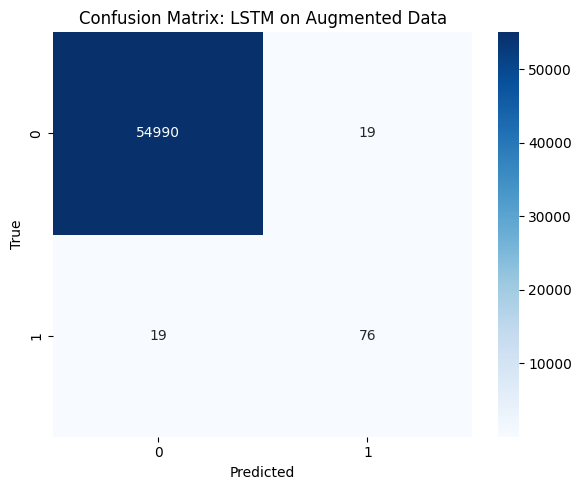

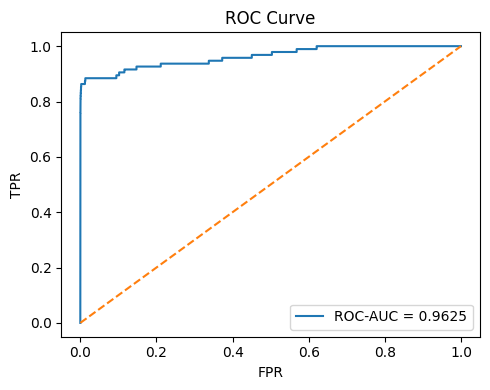

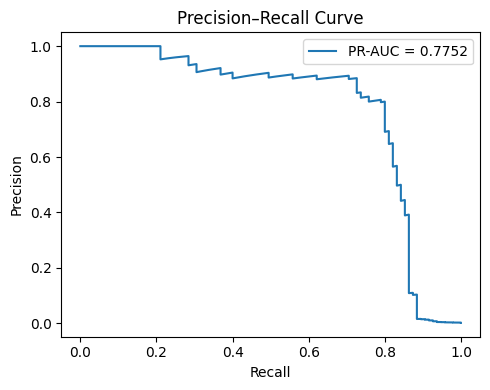

[Done]


In [ ]:
# ============================================================
# Full Script: Memory-efficient RNN (GRU/LSTM) Classifier
# ============================================================
# Expects you already have either:
#   (A) gen_X_train, gen_y_train, X_test, y_test
#       - augmented train features/labels (real + synthetic)
#   OR
#   (B) X_train, y_train, vae_gan_samples, X_test, y_test
#       - will build gen_X_train/gen_y_train for you.
# ============================================================

# --- 0) Imports & setup ---
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import mixed_precision

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    classification_report, confusion_matrix, f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mixed precision (good VRAM savings on GPU; safe on CPU too)
try:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        mixed_precision.set_global_policy("mixed_float16")
except Exception:
    pass

# --- 1) Config knobs (tune if you hit OOM) ---
USE_LSTM = True          # True = LSTM, False = GRU (GRU is lighter)
SEQ_LEN  = 30             # increase stride to reduce number of windows
STRIDE   = 1              # try 2 or 4 to cut memory further
BATCH    = 128            # if OOM: 64, 32
EPOCHS   = 10
LR       = 2e-4
UNITS    = 32             # shrink to 16 if needed
BIDIR    = False           # False if you need even smaller model
DROPOUT  = 0.30

# --- 2) Get training & test arrays ---
# Use (B) to auto-build augmented train set if needed
if 'gen_X_train' not in globals() or 'gen_y_train' not in globals():
    assert 'X_train' in globals() and 'y_train' in globals() and 'vae_gan_samples' in globals(), \
        "Provide gen_X_train/gen_y_train OR X_train/y_train/vae_gan_samples."
    print("[Info] Building augmented train set from X_train + vae_gan_samples ...")
    assert vae_gan_samples.shape[1] == X_train.shape[1], "Feature dims must match."
    gen_X_train = np.vstack([X_train, vae_gan_samples])
    gen_y_train = np.concatenate([y_train, np.ones(vae_gan_samples.shape[0], dtype=int)])

assert 'X_test' in globals() and 'y_test' in globals(), "Please provide X_test and y_test."

# Cast to compact dtypes
Xtr = gen_X_train.astype('float32', copy=False)
ytr = gen_y_train.astype('float32', copy=False)
Xte = X_test.astype('float32', copy=False)
yte = y_test.astype('float32', copy=False)

n_features = Xtr.shape[1]
print(f"[Data] Train: {Xtr.shape}, Test: {Xte.shape}, Features: {n_features}")

# --- 3) Streamed timeseries datasets (no giant arrays in RAM) ---
train_ds = timeseries_dataset_from_array(
    data=Xtr,
    targets=ytr,                 # aligns with last timestep in each window
    sequence_length=SEQ_LEN,
    sequence_stride=STRIDE,
    shuffle=True,
    batch_size=BATCH,
)

val_ds = timeseries_dataset_from_array(
    data=Xte,
    targets=yte,
    sequence_length=SEQ_LEN,
    sequence_stride=STRIDE,
    shuffle=False,
    batch_size=BATCH,
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# Rough counts (without materializing)
def approx_num_windows(n_rows, seq_len, stride):
    return max(0, (n_rows - seq_len) // stride + 1)
print(f"[Windows] ~train: {approx_num_windows(len(Xtr), SEQ_LEN, STRIDE)}  "
      f"~val: {approx_num_windows(len(Xte), SEQ_LEN, STRIDE)}")

# --- 4) Class weights to handle imbalance ---
pos = float(np.sum(ytr))
neg = float(len(ytr) - pos)
scale_pos_weight = (neg / max(pos, 1.0)) if pos > 0 else 1.0
class_weight = {0: 1.0, 1: scale_pos_weight}
print(f"[ClassWeight] {class_weight}")

# --- 5) Build model ---
tf.keras.backend.clear_session(); gc.collect()

def build_model(n_features, use_lstm=False, units=32, bidir=True, dropout=0.3):
    RNN = LSTM if use_lstm else GRU
    rnn = RNN(units, return_sequences=False)
    if bidir:
        rnn = Bidirectional(rnn)
    model = Sequential([
        Input(shape=(SEQ_LEN, n_features)),
        rnn,
        Dropout(dropout),
        # ensure numerically stable float32 head under mixed precision
        Dense(1, activation='sigmoid', dtype='float32'),
    ])
    return model

model = build_model(n_features, use_lstm=USE_LSTM, units=UNITS, bidir=BIDIR, dropout=DROPOUT)
model.compile(
    optimizer=Adam(LR),
    loss="binary_crossentropy",
    metrics=[
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="roc_auc"),
        AUC(name="pr_auc", curve="PR"),
    ],
)
model.summary()

cb = [
    callbacks.EarlyStopping(monitor="val_pr_auc", mode="max", patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

# --- 6) Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    verbose=2,
    callbacks=cb,
)

# --- 7) Evaluate (stream without storing huge arrays) ---
y_true_list, y_prob_list = [], []
for xb, yb in val_ds:
    yp = model.predict(xb, verbose=0).ravel()
    y_true_list.append(yb.numpy().ravel())
    y_prob_list.append(yp)

y_true = np.concatenate(y_true_list)
y_prob = np.concatenate(y_prob_list)

# Best-F1 threshold on PR
prec, rec, thr = precision_recall_curve(y_true, y_prob)
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.argmax(f1s)) if len(f1s) else 0
best_thr = float(thr[best_idx]) if thr.size else 0.5
y_pred = (y_prob >= best_thr).astype(int)

roc = roc_auc_score(y_true, y_prob)
pr  = average_precision_score(y_true, y_prob)
f1  = f1_score(y_true, y_pred)

print(f"\n[Metrics] ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1@{best_thr:.3f}: {f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# --- 8) Plots ---
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Confusion Matrix: {'LSTM' if USE_LSTM else 'GRU'} on Augmented Data")
plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.tight_layout(); plt.show()

# PR curve
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"PR-AUC = {pr:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.legend()
plt.tight_layout(); plt.show()

print("[Done]")


The combination of VAE-GAN for data augmentation and LSTM for classification demonstrates strong performance in fraud detection:

High overall accuracy (99.93%) → The model reliably distinguishes between fraudulent and non-fraudulent transactions.

ROC-AUC (0.9625) → Excellent ability to separate positive (fraud) from negative (legitimate) classes across thresholds.

PR-AUC (0.7752) → Strong precision-recall tradeoff, which is important in highly imbalanced fraud datasets.

F1-score (0.80 for fraud class) → Balanced precision and recall, showing the model detects fraud effectively without too many false alarms.

Confusion Matrix → Out of 95 fraud cases, 76 were correctly identified, with only 19 missed (FN) and 19 false alarms (FP) among ~55k legitimate transactions.

The VAE-GAN augmentation improved fraud detection by providing synthetic but realistic samples, helping the LSTM learn better fraud patterns. Although a few fraud cases are still misclassified, the model achieves a good balance between sensitivity (recall) and precision, which is crucial in real-world fraud detection.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Generative adversarial network for oversampling data in credit card fraud detection](https://link.springer.com/chapter/10.1007/978-3-030-36945-3_7),[ The importance of future information in credit card fraud detection](https://arxiv.org/abs/2204.05265), https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code

Note- ChatGPT used for understanding results and help with lstm code to use less memory.